In [2]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({"font.size": 15, 
                            "font.family": "STIXGeneral",
                            "mathtext.fontset": "cm"})

In [3]:
glue_tasks = ["CoLA", "SST-2", "Sara"]
metrics = {
    "CoLA": "MCC",
    "SST-2": "accuracy",
    "Sara": "micro-avg F1"
}
model_types = {
    "main": ["teacher", "BERT", "LSTM"],
    "additional": ["scratch", "hard-logits"]
}
model_type_bar_hatches = {
    "main": "",
    "scratch": "//",
    "hard-logits": "x"
#     ('-', '+', 'x', '\\', '*', 'o', 'O', '.')
}
model_colours = { # http://mkweb.bcgsc.ca/colorblind/
    "teacher": (150, 75, 0), # brown (0, 0, 0), # black
    "LSTM": (86, 180, 233), # sky blue
    "BERT": (230, 159, 0), # orange
    "embedding": (0, 114, 178) # blue
}
model_colours = {name: np.array(c)/255 for name, c in model_colours.items()}

best_model_scores = {
    "CoLA": {
        "teacher": 59.9,
        "BERT": 45.0,
        "BERT-scratch": 35.2,
        "BERT-hard-logits": 37.3,
        "LSTM": 44.2, # 44.8
        "LSTM-scratch": 37.5,
        "LSTM-hard-logits": 38.4
    },
    "SST-2": {
        "teacher": 91.5,
        "BERT": 89.3, # 89.2
        "BERT-scratch": 87.4,
        "BERT-hard-logits": 86.7,
        "LSTM": 91.2, # 91.9
        "LSTM-scratch": 90.8,
        "LSTM-hard-logits": 90.6
    },
    "Sara": {
        "teacher": 87.5,
        "BERT": 87.1,
        "BERT-scratch": 86.0,
        "BERT-hard-logits": 84.1,
        "LSTM": 86.5,
        "LSTM-scratch": 85.6,
        "LSTM-hard-logits": 84.9
    },
}

with open("predictions/eval_prediction_entropies.pkl", 'rb') as handle:
    eval_prediction_entropies = pickle.load(handle)

# Comparing performance of best models

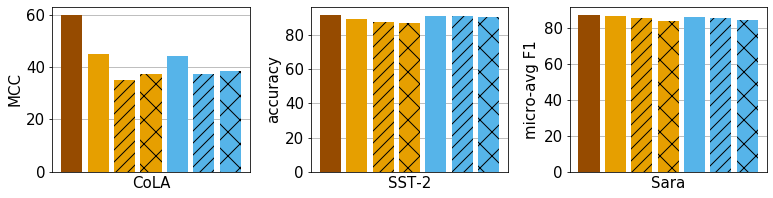

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 3))
for ax, task in zip(axs, glue_tasks):
    results = [best_model_scores[task]["teacher"]]
    colours = [model_colours["teacher"]]
    hatches = [model_type_bar_hatches["main"]]
    for main_model_type in ["BERT", "LSTM"]:
        all_model_types = [main_model_type] + [(main_model_type + "-" + additional) for additional in model_types["additional"]]
        colours += [model_colours[main_model_type] for _ in range(len(model_types["additional"])+1)]
        hatches += [model_type_bar_hatches[model_type] for model_type in (["main"] + model_types["additional"])]
        for model_type in all_model_types:
            results.append(best_model_scores[task][model_type])
    ax.bar(range(len(results)), results, color=colours)
    for bar, hatch in zip(ax.patches, hatches): bar.set_hatch(hatch)
    ax.set_ylabel(metrics[task])
    ax.set_xlabel(task)
    ax.tick_params(axis="x", labelbottom=False, length=0)
    ax.grid(axis="y")
    ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

# Comparing best models' eval-set prediction entropy

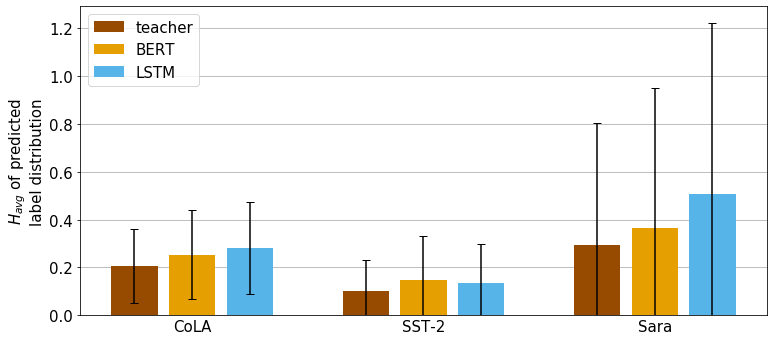

In [12]:
fig = plt.figure(figsize=(11, 5))
ax = plt.gca()
for i, task in enumerate(glue_tasks):
    for j, model_type in enumerate(model_types["main"]):
        ax.bar(j+i*(1+len(model_types["main"])), 
               eval_prediction_entropies[task][model_type]["mean"], 
               color=model_colours[model_type],
               label=(model_type if i == 0 else None),
               yerr=eval_prediction_entropies[task][model_type]["std"], capsize=4)
ax.legend(loc=2)
ax.set_xticks([(1 + i*(1+len(model_types["main"]))) for i in range(3)])
ax.set_ylim(bottom=0)
ax.set_xticklabels(glue_tasks)
ax.tick_params(axis="x", length=0)
ax.grid(axis="y")
ax.set_axisbelow(True)
ax.set_ylabel("$H_{avg}$ of predicted\nlabel distribution")
plt.tight_layout()
plt.show()

# Comparing best models' eval-set prediction average confidence

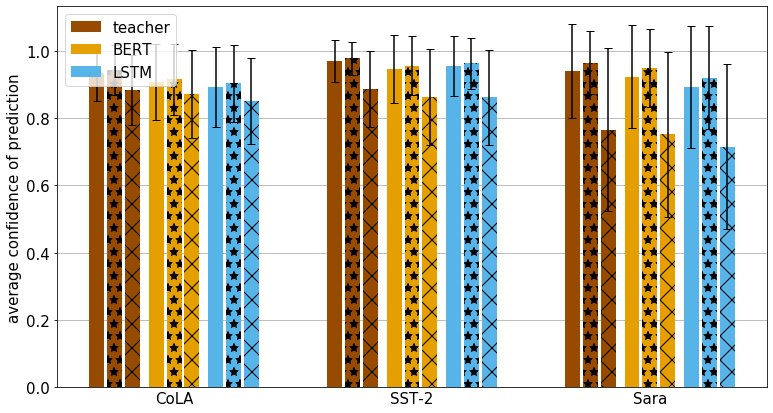

In [13]:
fig = plt.figure(figsize=(11, 6))
ax = plt.gca()
for i, task in enumerate(glue_tasks):
    for j, model_type in enumerate(model_types["main"]):
        data = pd.read_csv("predictions/dev_scored_{}_{}.tsv".format(task, model_type), delimiter="\t")
        confidence = data["certainty_of_pred"].mean()
        confidence_hits = data[data["label"] == data["pred"]]["certainty_of_pred"].mean()
        confidence_misses = data[data["label"] != data["pred"]]["certainty_of_pred"].mean()
        confidence_std = data["certainty_of_pred"].std()
        confidence_hits_std = data[data["label"] == data["pred"]]["certainty_of_pred"].std()
        confidence_misses_std = data[data["label"] != data["pred"]]["certainty_of_pred"].std()
        w = 0.25
        gap = 0.05
        capsize = 4
        ax.bar(j+i*(1+len(model_types["main"]))-w-gap,
               confidence, width=w,
               color=model_colours[model_type],
               label=(model_type if i == 0 else None),
               yerr=confidence_std, capsize=capsize)
        ax.bar(j+i*(1+len(model_types["main"])),
               confidence_hits, hatch="*", width=w,
               color=model_colours[model_type],
               yerr=confidence_hits_std, capsize=capsize)
        ax.bar(j+i*(1+len(model_types["main"]))+w+gap,
               confidence_misses, hatch="x", width=w,
               color=model_colours[model_type],
               yerr=confidence_misses_std, capsize=capsize)
ax.legend(loc=2)
ax.set_xticks([(1 + i*(1+len(model_types["main"]))) for i in range(3)])
ax.set_ylim(bottom=0)
ax.set_xticklabels(glue_tasks)
ax.tick_params(axis="x", length=0)
ax.grid(axis="y")
ax.set_axisbelow(True)
ax.set_ylabel("average confidence of prediction")
plt.tight_layout()
plt.show()

# Comparing best models' eval-set prediction confidence distributions

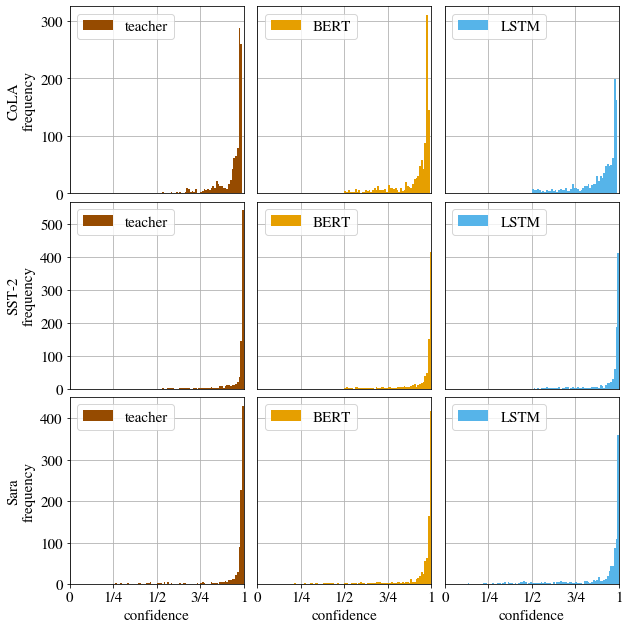

In [55]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 9), sharex=True, sharey=False)

for i, task in enumerate(glue_tasks):
    axs[i, 0].set_ylabel(task + "\nfrequency")
    max_heights = []
    for j, model_type in enumerate(model_types["main"]):        
        data = pd.read_csv("predictions/dev_scored_{}_{}.tsv".format(task, model_type), delimiter="\t")
        confidences = data["certainty_of_pred"]
        ax = axs[i, j]
        rects = ax.hist(confidences, bins=100, range=(0,1), color=model_colours[model_type], 
                        label=model_type, log=False)
        ax.set_xlim(0, 1.0)
        if j > 0:
            ax.tick_params(axis="y", length=0, labelleft=False)
        if i < 2:
            ax.tick_params(axis="x", length=0)
        else:
            ax.set_xlabel("confidence")
        max_height = max(rects[0])
        max_heights.append(max_height)
        ax.legend(loc=2)
        ax.grid(axis="y", which="both")
        ax.grid(axis="x", which="both")
        ax.set_axisbelow(True)
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1.])
        ax.set_xticklabels(["0", "1/4", "1/2", "3/4", "1"])
    for j, _ in enumerate(model_types["main"]):
        axs[i, j].set_ylim(0, max(max_heights)*1.05)
plt.tight_layout(w_pad=0.4, h_pad=0.0)
plt.show()